<a href="https://colab.research.google.com/github/Lamiv/nlp/blob/master/cw_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Amazon fine foods review analysis

Part 1 

1.   Preprocessing
2.   Normalization



In [0]:
pip install pandarallel

In [0]:
import nltk
import re
import numpy as np
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from multiprocessing import  Pool
from nltk.corpus import wordnet

from pandarallel import pandarallel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Check number of processors.
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [0]:
# Function to run any function in parallel processing.
def execute_in_parallel(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

#**Data Loading and Exploration**

### Load the data



In [0]:
sourcefile = "/content/drive/My Drive/Colab Notebooks/train.csv"
stemfile = "/content/drive/My Drive/Colab Notebooks/train_stemmer.csv"
stemzip = "/content/drive/My Drive/Colab Notebooks/train_stemmer.zip"
lemfile = "/content/drive/My Drive/Colab Notebooks/train_lem.csv"
lemzip = "/content/drive/My Drive/Colab Notebooks/train_lem.zip"

In [0]:
traindf = pd.read_csv(sourcefile)

In [0]:
#save some time in re-processing. load the file from stemfile
#traindf = pd.read_csv(stemfile)

In [0]:
print("Type of traindf" , type(traindf))


Type of traindf <class 'pandas.core.frame.DataFrame'>


### Exploration

In [0]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
Id                        426340 non-null int64
ProductId                 426340 non-null object
UserId                    426340 non-null object
ProfileName               426326 non-null object
HelpfulnessNumerator      426340 non-null int64
HelpfulnessDenominator    426340 non-null int64
Score                     426340 non-null int64
Time                      426340 non-null int64
Summary                   426320 non-null object
Text                      426340 non-null object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB


In [0]:
traindf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller!...
1,225833,B001I7HJE4,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1190160000,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...
2,350901,B000LKTB90,A1BBPP1EC75JX4,"Johan Bollen ""gekhond""",0,0,5,1285977600,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,..."
3,299801,B001HXJPS2,A5QSI9MNS8NMS,M. Esaili,0,0,5,1338163200,Lindt is Lindt,Buying this multi-pack I was misled by the pic...
4,48472,B006H34CUS,A20IBAIRSNBEAQ,Chelsea,0,0,5,1343606400,YUM!!!!!,These bars are so good! I loved them warmed up...


In [0]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
Id                        426340 non-null int64
ProductId                 426340 non-null object
UserId                    426340 non-null object
ProfileName               426326 non-null object
HelpfulnessNumerator      426340 non-null int64
HelpfulnessDenominator    426340 non-null int64
Score                     426340 non-null int64
Time                      426340 non-null int64
Summary                   426320 non-null object
Text                      426340 non-null object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB


In [0]:
traindf.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,426340.000000,426340.000000,426340.000000,426340.000000,4.263400e+05
mean,284300.799618,1.733159,2.220244,4.183455,1.296222e+09
std,164012.600602,7.328184,8.014894,1.310577,4.808061e+07
min,1.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,142363.750000,0.000000,0.000000,4.000000,1.271203e+09
50%,284308.500000,0.000000,1.000000,5.000000,1.311034e+09
75%,426183.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,844.000000,923.000000,5.000000,1.351210e+09


In [0]:
print("Number of Reviews per Score: \n {}".format(traindf.groupby(['Score'])['Id'].count()))
#traindf.groupby(['Score'])['Id'].count()

Number of Reviews per Score: 
 Score
1     39193
2     22353
3     31993
4     60309
5    272492
Name: Id, dtype: int64


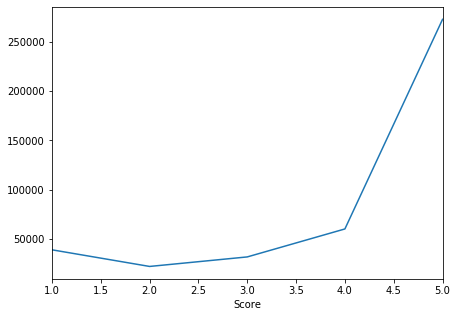

In [0]:
#plot data
fig, ax = plt.subplots(figsize=(7,5))
traindf.groupby(['Score']).count()['Id'].plot(ax=ax)

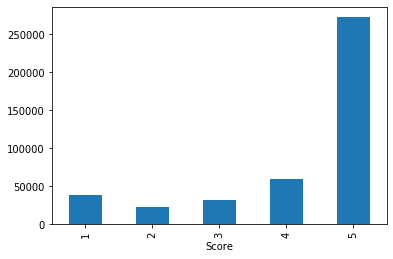

In [0]:
df = pd.DataFrame(data = traindf)
df = df.replace(np.nan,0)
df = df.groupby(['Score']).count()['Id']
df.plot.bar()
#ax = df.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13);
#ax.set_alpha(0.8)
#ax.set_title("My Bar Plot", fontsize=22)
#ax.set_ylabel("Some Heading on Y-Axis", fontsize=15);
#plt.show()

In [0]:
traindf.loc[1,'Text']

'*****<br />Numi\'s Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called "teasans"):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen\'s Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts

In [0]:
traindf.loc[0,'Text']

'I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.'

In [0]:
traindf.loc[100,'Text']

'This review is for the Slim Jim .28oz (Pack of 100) Meat Snacks. Being a Type 2 diabetic, these are great snacks to have on hand since they are very low in carbs. The flavor is just spicy enough to make them interesting, but is certainly not overpowering.<br /><br />The casing is a little tough and it does seam a little more greasy than my favorite meat snack, <a href="http://www.amazon.com/gp/product/B000GW0UGG">Jack Link\'s X-Stick, Original, 0.5-Ounce X-Sticks (Pack of 50)</a>, but the smaller size makes Slim Jim good for a "pocket snack".<br /><br />Recommended!<br /><br />CFH'

In [0]:
print("Number of reviewed products: {}".format(traindf["ProductId"].nunique()))
print("Number of users participated: {}".format(traindf["UserId"].nunique()))

Number of reviewed products: 65858
Number of users participated: 210008


In [0]:
pcount = traindf.groupby(['ProductId'])['Id'].count()
pcount.sort_values(axis=0, ascending=False )

ProductId
B007JFMH8M    667
B002QWP89S    478
B002QWP8H0    477
B002QWHJOU    477
B0026RQTGE    466
             ... 
B002W8LMH8      1
B002W5OA8Y      1
B002W51EWY      1
B002W4IZ4K      1
B001TP0EBA      1
Name: Id, Length: 65858, dtype: int64

#**Normalization** 
Cleanup the data, then enrich it , stemming and lematization





## Cleanup

In [0]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
Id                        426340 non-null int64
ProductId                 426340 non-null object
UserId                    426340 non-null object
ProfileName               426326 non-null object
HelpfulnessNumerator      426340 non-null int64
HelpfulnessDenominator    426340 non-null int64
Score                     426340 non-null int64
Time                      426340 non-null int64
Summary                   426320 non-null object
Text                      426340 non-null object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB


In [0]:
#sorting the data before removing duplicates
sorted_data=traindf.sort_values(["UserId","Score","Summary","Text"],ascending=True,inplace=False,kind='quicksort',na_position='last')
sorted_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
109293,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,5,1343088000,Great for the Price,I have to say I was a little apprehensive to b...
70602,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,5,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...
80036,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...
89988,378693,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0,0,3,1310601600,Some damage,The shipment of the dog food was quick. Howev...
5800,136545,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0,0,1,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."


**1. De-Duplication**



In [0]:
#drop_duplicates 
# ignore product id, look at if same user gave same score with same text
# same Score, userid and text can help
final=sorted_data.drop_duplicates(subset={"UserId","Score","Summary","Text"},keep='first',inplace=False)
print(final.shape)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(309191, 10)


(309190, 10)

In [0]:
#percentage of data remaining after removing duplicates to the data we initially took.
duplicates = (traindf['Id'].size*1.0) - (final['Id'].size*1.0)
percent = (final['Id'].size*1.0)/(traindf['Id'].size*1.0)*100
print('Duplicate records: ', duplicates)
print('Unique ratio: ', percent)
print('Deduplicated data set len: ', final['Id'].size*1.0)
traindf = final

Duplicate records:  117150.0
Unique ratio:  72.52193085330957
Deduplicated data set len:  309190.0


**Handling** **NA** 

In [0]:
traindf.Summary.fillna(' ', inplace=True)
traindf.Text.fillna(' ', inplace=True)

Merge Text and Summary to Form "REVIEW", then do cleanup on REVIEW

1.   Remove HTML tags
2.   Remove numbers
3.   Remove [] 
4.   Remove &, -, '_'





In [0]:
def remove_html(text):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [0]:
def remove_square(text):
  return re.sub('\[[^]]*\]', '', text)
  

In [0]:
def remove_number(text):
  return re.sub(r'\d+', '', text)

In [0]:
def extract_alpha(text):
  #return re.sub(r'\W+',' ', text)
  return re.sub(r'[^A-Za-z]+',' ', text)


In [0]:
def meaningful_sub(text):
  return re.sub(r'(?<= )&(?= )', "and", text)

In [0]:
def do_some_cleaning(text):
  text = remove_html(text)
  text = remove_square(text)
  #text = meaningful_sub(text)
  text = extract_alpha(text)
  #text = remove_number(text)
  return text


In [0]:
def merge_then_clean(df):
  df['Review'] = traindf[traindf.columns[8:]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)
  df['Review'] = df.apply(lambda row: do_some_cleaning(row['Review']), axis=1)
  return df

In [0]:
#traindf = merge_then_clean(traindf)
#traindf = execute_in_parallel(traindf, merge_then_clean, mp.cpu_count())
pandarallel.initialize()
traindf['Review'] = traindf[traindf.columns[8:]].parallel_apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [0]:
pandarallel.initialize()
traindf['Review'] = traindf.parallel_apply(lambda row: do_some_cleaning(row['Review']), axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [0]:
#drop some coloumns, as we do not need it now.
originaldf = pd.DataFrame(traindf)
traindf = traindf.drop(['ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Summary','Text'], axis = 1)

In [0]:
traindf.head()

,Id,Score,Time,Review
109293,136323,5,1343088000,Great for the Price I have to say I was a litt...
70602,516062,5,1350086400,AWESOME Coffee Received my free K cups as a sa...
80036,516079,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K Cups ...
89988,378693,3,1310601600,Some damage The shipment of the dog food was q...
5800,136545,1,1342483200,Less than satisfactory I gave the Brooklyn K C...


In [0]:
traindf.tail()

,Id,Score,Time,Review
206340,338489,5,1329436800,Just what I needed This is a great addition to...
423327,190698,5,1268179200,pretty amazing i ve wanted one of these since ...
369037,222781,5,1309737600,I Have Spoken All of the chocolate arrived wit...
425126,131469,5,1337472000,Amazing flavor I use this all the time Good fo...
162126,183897,2,1333497600,Disappointed I ordered this cereal based on th...


In [0]:
traindf.loc[1,'Review']

'Organic Kosher Tasty Assortment of Premium Teas Teasans Numi s Collection Assortment Melange includes Herbal Teas caffeine free also called teasans Dry Desert Lime Lime Herbal Teasan Fields of Gold Lemongrass Herbal Teasan Red Mellow Bush Rooibos Herbal Teasan Bushmen s Brew Honeybush Herbal Teasan Simply Mint Moroccan Mint Green Teas lower in caffeine Temple of Heaven Gunpowder Green Tea Monkey King Jasmine Green Tea Black Teas contain caffeine Chinese Breakfast Yunnan Black Tea Smoky Tarry Lapsang Souchong Black TeaThis is a total of nine different teas two tea bags of each one in each box Numi teas are known for their high quality organic and kosher ingredients and in my opinion are some of the tastiest and best teas I have ever tried They do not include artificial ingredients or flavorings On the box the manufacturer writes From mist covered mountains to sun drenched deserts to fertile fields we proudly bring you our tea palette The flavors range from smooth earthiness and light f

In [0]:
traindf.loc[0,'Review']

'Very Good I received this product early from the seller They are a very tastey a Great mid day snack I have shared them with my Glutten Free Friends they will be ordering this product more very soon Very Good I received this product early from the seller They are a very tastey a Great mid day snack I have shared them with my Glutten Free Friends they will be ordering this product more very soon '

In [0]:
originaldf.to_csv(stemfile)

**Lets see how many reviews available against the scrores** 


In [0]:
traindf.groupby('Score').count()

,Id,Time,Review
Score,,,
1,28531,28531,28531
2,16290,16290,16290
3,23302,23302,23302
4,43879,43879,43879
5,197188,197188,197188


## Enrich

Introduce a new coloumn , so reviews with score more than 3 are positive, and below 3 are negative, 3 is neutral. Posive gets +1, negative -1 and neutral is 0

In [0]:
traindf['Positivity'] = np.where(traindf['Score'] > 3, 1, np.where(traindf['Score'] < 3, -1, 0))

In [0]:
traindf.groupby('Positivity').count()

,Id,Score,Time,Review
Positivity,,,,
-1,44821,44821,44821,44821
0,23302,23302,23302,23302
1,241067,241067,241067,241067


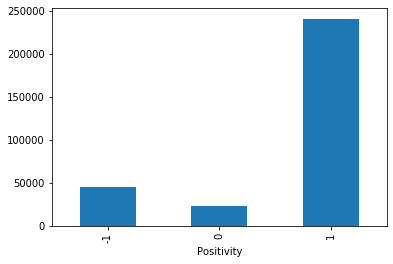

In [0]:
df = pd.DataFrame(data = traindf)
df = df.replace(np.nan,0)
df = df.groupby(['Positivity']).count()['Score']
df.plot.bar()

In [0]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

positivity_label = ['Negative','Neutral','Positive']
values = array(positivity_label)
print(values)

['Negative' 'Neutral' 'Positive']


## **Stemming**

**Tokenize**

In [0]:
#tokenize and remove stop words
def tokenize_wo_stop(text):
  text1 = text
  text1 = text1.lower()
  stop_words = set(stopwords.words('english'))
  words      = word_tokenize(text1)
  filtered   = [] 
  #filter stop words from words
  for word in words: 
    if word not in stop_words: 
        filtered.append(word) 
  
  return words


In [0]:
token1 = tokenize_wo_stop(traindf.loc[0,'Review'])
print(traindf.loc[0,'Review'])
print(token1)

Very Good I received this product early from the seller They are a very tastey a Great mid day snack I have shared them with my Glutten Free Friends they will be ordering this product more very soon Very Good I received this product early from the seller They are a very tastey a Great mid day snack I have shared them with my Glutten Free Friends they will be ordering this product more very soon 
['very', 'good', 'i', 'received', 'this', 'product', 'early', 'from', 'the', 'seller', 'they', 'are', 'a', 'very', 'tastey', 'a', 'great', 'mid', 'day', 'snack', 'i', 'have', 'shared', 'them', 'with', 'my', 'glutten', 'free', 'friends', 'they', 'will', 'be', 'ordering', 'this', 'product', 'more', 'very', 'soon', 'very', 'good', 'i', 'received', 'this', 'product', 'early', 'from', 'the', 'seller', 'they', 'are', 'a', 'very', 'tastey', 'a', 'great', 'mid', 'day', 'snack', 'i', 'have', 'shared', 'them', 'with', 'my', 'glutten', 'free', 'friends', 'they', 'will', 'be', 'ordering', 'this', 'product'

In [0]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer('english')

In [0]:
traindf.Review.fillna(' ', inplace=True)

In [0]:
# Stemming the tokens
def stem_sentence(words, use=1):
  if use==1:
    stemmedTokens = [porter.stem(word) for word in words]
  elif use==2:
    stemmedTokens = [lancaster.stem(word) for word in words]
  else:
    stemmedTokens = [snowball.stem(word) for word in words]
  return ' '.join(stemmedTokens)


In [0]:
#Tokenize and then Apply various stemmers to the Tokens
def tokenize(df):
  df['Tokens'] =  df.apply(lambda row: tokenize_wo_stop(row['Review']), axis=1)
  return df
def portstem(df):
   df['PortStem'] =  df.apply(lambda row: stem_sentence(row['Tokens'],1), axis=1)
   return df
def lanstem(df):
  df['LancStem'] =  df.apply(lambda row: stem_sentence(row['Tokens'],2), axis=1)
  return df
def snowstem(df):
  df['SnowStem'] =  df.apply(lambda row: stem_sentence(row['Tokens'],3), axis=1)
  return df
  

In [0]:
traindf.head()

,Id,Score,Time,Review,Positivity
109293,136323,5,1343088000,Great for the Price I have to say I was a litt...,1
70602,516062,5,1350086400,AWESOME Coffee Received my free K cups as a sa...,1
80036,516079,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K Cups ...,1
89988,378693,3,1310601600,Some damage The shipment of the dog food was q...,0
5800,136545,1,1342483200,Less than satisfactory I gave the Brooklyn K C...,-1


In [0]:
#Tokenize and Stem
#traindf = execute_in_parallel(traindf, tokenize, mp.cpu_count())
pandarallel.initialize()
traindf['Tokens'] =  traindf.parallel_apply(lambda row: tokenize_wo_stop(row['Review']), axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [0]:
traindf = execute_in_parallel(traindf, portstem, mp.cpu_count())

In [0]:
traindf = execute_in_parallel(traindf, snowstem, mp.cpu_count())

In [0]:
traindf = execute_in_parallel(traindf, lanstem, mp.cpu_count())

*Using parallel processing, the stemming took 773 seconds*

Original Text looks like this:

**PorterStemmer** uses Suffix Stripping to produce stems. 


>PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems

---

*`PorterStemmer is known for its simplicity and speed. It is commonly useful in Information Retrieval Environments known as IR Environments for fast recall and fetching of search queries.
 In a typical IR, environment documents are represented as vectors of words or terms. `*



In [0]:
#traindf['PortStem'] =  traindf.apply(lambda row: stem_sentence(row['Review'],1), axis=1)


In [0]:
traindf.loc[1,'PortStem']

**The LancasterStemmer** (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix.

>   On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

---

*`LancasterStemmer is simple, but heavy stemming due to iterations and over-stemming may occur. Over-stemming causes the stems to be not linguistic, or they may have no meaning.`*



In [0]:
#traindf['LancStem'] =  traindf.apply(lambda row: stem_sentence(row['Review'],2), axis=1)

In [0]:
traindf.loc[1,'LancStem']

In [0]:
#split trainset, test set for Lancaster Stemmer
#from sklearn.model_selection import train_test_split
#X_lstrain, X_lstest, y_lstrain, y_lstest = train_test_split(df['Lanctem'], df['Score'], random_state = 0)


In [0]:
#save the dataframe to csv
traindf.to_csv(stemfile, index=False)  

## **Lemmatization**

###Lemmatization using NLTK

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

In [0]:
def get_pos_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:          
    return None

In [0]:
def lemmatize(tokens):
  nltk_tagged = nltk.pos_tag(tokens)  
  wn_tagged = map(lambda x: (x[0], get_pos_tag(x[1])), nltk_tagged)
  lem_words = []
  for word, tag in wn_tagged:
    if tag is None:            
      lem_words.append(word)
    else:
      lem_words.append(lemmatizer.lemmatize(word, tag))
  return " ".join(lem_words)

In [0]:
def lemmatize_df(df) :
  df['Lemmat'] =  df.apply(lambda row: lemmatize(row['Tokens']), axis=1)  

In [0]:
sample = lemmatize(traindf.loc[1,'Tokens'])
print(sample)

organic kosher tasty assortment of premium tea teasans numi s collection assortment melange include herbal tea caffeine free also call teasans dry desert lime lime herbal teasan field of gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushman s brew honeybush herbal teasan simply mint moroccan mint green tea lower in caffeine temple of heaven gunpowder green tea monkey king jasmine green tea black tea contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black teathis be a total of nine different tea two tea bag of each one in each box numi tea be know for their high quality organic and kosher ingredient and in my opinion be some of the tastiest and best tea i have ever try they do not include artificial ingredient or flavoring on the box the manufacturer write from mist cover mountain to sun drenched desert to fertile field we proudly bring you our tea palette the flavor range from smooth earthiness and light floral scent to refreshingly 

In [0]:
#traindf = execute_in_parallel(traindf, lemmatize_df, mp.cpu_count())
pandarallel.initialize()
tokendf = traindf.Tokens.parallel_apply(lemmatize)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [0]:
tokendf.describe()

count                                                309190
unique                                               308795
top       my th favorite flavor diamond almondsalmonds b...
freq                                                      5
Name: Tokens, dtype: object

In [0]:
tokendf['Tokens'] = pd.DataFrame(tokendf)
tokendf['Score'] = traindf['Score']
traindf['Lemmat'] = tokendf['Tokens']


In [0]:
traindf.to_csv(lemfile)

## Vectorization

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vect1 = CountVectorizer(min_df=10,stop_words="english",lowercase=True,strip_accents='ascii').fit(traindf['Lemmat'])
#vect1 is unigram 

In [0]:
print(vect1)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [0]:
feature_names = vect1.get_feature_names()
print('No. of features in Uni-gram Vect = ',len(feature_names))

No. of features in Uni-gram Vect =  17624


In [0]:
print('First 2000 Features are: \n{}'.format(feature_names[::2000]))

First 2000 Features are: 
['aa', 'abby', 'able', 'absence', 'absorbed', 'absurdly', 'abysmal', 'accentuate', 'accidentally', 'accomplished', 'accross', 'accustomed', 'achiote', 'ackee', 'acquisition', 'actively', 'acutally', 'adapt', 'addicted', 'additives', 'adjacent', 'administration', 'adolescent', 'adrenal', 'advent', 'advertised', 'advisable', 'aerator', 'aesthetically', 'afficionado', 'affordably', 'afterlife', 'afterwords', 'aggravate', 'ago', 'agricultural', 'ahhhh', 'aide', 'airbrush', 'aisles', 'al', 'alba', 'alcohol', 'alergies', 'algae', 'alittle', 'allege', 'allergies', 'allow', 'allure', 'aloe', 'alpo', 'alternative', 'altura', 'amaranth', 'amazing', 'ambien', 'amd', 'americanize', 'aminos', 'amoretti', 'amt', 'anal', 'ancho', 'andi', 'anecdotal', 'angie', 'ankle', 'anniversary', 'annually', 'anthon', 'antidote', 'antiperspirant', 'anxiously', 'anywho', 'apiece', 'appal', 'appease', 'applesauce', 'applies', 'appreciative', 'approx', 'apron', 'aquired', 'arbor', 'area', 'a

In [0]:
print("Last 2000 Features:\n{}".format(feature_names[2000:]))

Last 2000 Features:
['burner', 'burning', 'burnt', 'burp', 'burr', 'burrito', 'burritos', 'burrow', 'burst', 'bursting', 'burton', 'bury', 'bus', 'bush', 'bushy', 'business', 'bust', 'busted', 'bustello', 'bustelo', 'buster', 'busy', 'butcher', 'buti', 'butler', 'butt', 'butter', 'buttercream', 'buttered', 'butterfinger', 'butterfingers', 'butterfly', 'buttermilk', 'butternut', 'butterscotch', 'butterworth', 'buttery', 'butthe', 'button', 'bux', 'buy', 'buyer', 'buying', 'buys', 'buzz', 'buzzworthy', 'bye', 'bypass', 'byproduct', 'byproducts', 'byzantine', 'bzz', 'bzzagent', 'ca', 'cab', 'cabbage', 'cabernet', 'cabin', 'cabinet', 'cable', 'cacao', 'cache', 'cachet', 'cacoa', 'cactus', 'cadbury', 'cadburys', 'caddy', 'cadet', 'cadillac', 'caesar', 'caf', 'cafe', 'cafes', 'cafeteria', 'caff', 'caffe', 'caffee', 'caffein', 'caffeinate', 'caffeinated', 'caffeine', 'caffienated', 'caffiene', 'caffinated', 'caffine', 'cafix', 'cage', 'cairn', 'cajole', 'cajun', 'cake', 'cakesters', 'cakey', 

In [0]:
vect2 = CountVectorizer(min_df=10,lowercase=True,strip_accents='ascii', ngram_range=(1,2)).fit(traindf['Lemmat'])
#vect2 is bi-gram 


In [0]:
feature_names_2 = vect2.get_feature_names()
print('Bigram features are total of : ', len(feature_names_2))
print('First 2000 Features are: \n {}', feature_names_2[::2000])

In [0]:
vect3 = CountVectorizer(min_df=10,stop_words="english",lowercase=True,strip_accents='ascii', ngram_range=(1,3)).fit(traindf['Lemmat'])
#vect3 is tri-gram 

In [0]:
feature_names_3 = vect3.get_feature_names()
print('Trigram features are total of : ', len(feature_names_3))
print('First 2000 Features are: \n {}', feature_names_3[::2000])

In [0]:
y_train = traindf['Score']

In [0]:
x_train1 = vect1.fit_transform(traindf['Review']) #uni gram
x_train2 = vect2.fit_transform(traindf['Review']) #bi gram
x_train3 = vect3.fit_transform(traindf['Review']) #tri gram

Some sample from the transform:

In [0]:
#print('X_Train1 NZ: ', x_train1.getnnz())
#print('X_Train2 NZ: ', x_train2.getnnz())
#print('X_Train3 NZ: ', x_train3.getnnz())